#Импорт библиотек + загрузка данных

In [ ]:
#!pip install wordcloud

     ------------------------------------ 153.3/153.3 kB 831.7 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [80]:
import pandas as pd
from nltk.corpus import stopwords
from pymystem3 import Mystem
import nltk
from datetime import datetime
import re
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import tqdm
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import razdel
import requests
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.probability import FreqDist
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import pickle
import nltk
from pytils import numeral
import pymorphy2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [99]:
SEED = 137

In [5]:
df = pd.read_csv('labeled.csv')

In [6]:
df

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


#1. Анализ данных

Смотрим на сырые данные

In [8]:
for i in range(50):
  print(df.comment.iloc[i])

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)

Для каких стан является эталоном современная система здравоохранения РФ? Для Зимбабве? Ты тупой? хохлы

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РАЗВОРУЮТ КАК ВСЕГДА! УЖЕ ТРЕЩИНАМИ ПОШ Л! ТУПЫЕ КИТАЗЫ НЕ МОГУТ 

Смотрим что по распределению классов

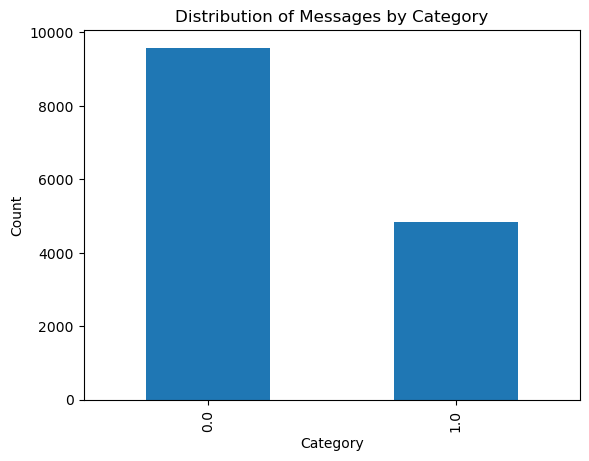

In [9]:
df['toxic'].value_counts().plot(kind='bar')
plt.title('Distribution of Messages by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

Обрабатываем данные

In [13]:
stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    # Приведение текста к нижнему регистру
    text = text.lower()
    # Удаление пунктуации
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Токенизация текста
    tokens = word_tokenize(text)
    # Удаление стоп-слов
    tokens = [token for token in tokens if not token in stop_words]
    # Лемматизация слов
    lemmatized_tokens = []
    for token in tokens:
        # Получение нормальной формы слова с помощью pymorphy2
        lem_token = morph.parse(token)[0].normal_form
        lemmatized_tokens.append(lem_token)
    return lemmatized_tokens

In [14]:
df['comment'] = df['comment'].apply(preprocess_text)

Смотрим встречаемость слов

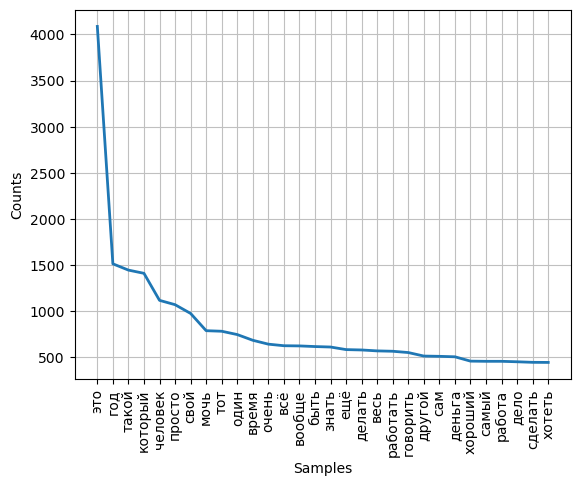

In [18]:
all_tokens = [token for doc in df['comment'] for token in doc]
freq_dist = FreqDist(all_tokens)
freq_dist.plot(30, cumulative=False)
plt.show()

Строим облако слов

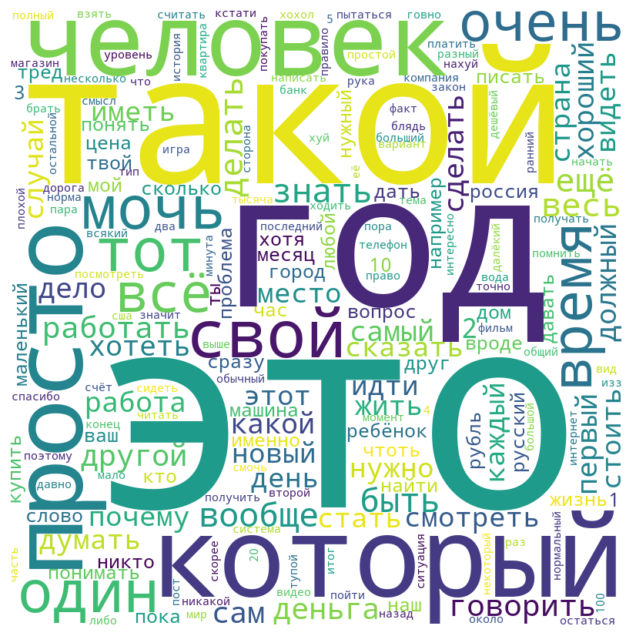

In [19]:
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(freq_dist)
plt.figure(figsize=[8,8])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Количество уникальных слов в каждом сообщении

In [48]:
unique_word_count = [len(set(doc)) / len(doc) for doc in df.comment]
average_unique_word_count = sum(unique_word_count) / len(unique_word_count)
print(f"Среднее количество уникальных слов в каждом сообщении: {average_unique_word_count}")

Среднее количество уникальных слов в каждом сообщении: 0.9588411061854475


Разделяем на тестовую и тренировочные выборки

In [83]:
train_data, val_data, train_labels, val_labels = train_test_split(df['lemmatized_str'], df['toxic'], test_size=0.2, random_state=SEED)

# Оценка баланса классов в тренировочной и валидационной выборках
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

print('Train class counts:', dict(train_counts))
print('Val class counts:', dict(val_counts))




import locale

locale.setlocale(locale.LC_ALL, "ru_RU.UTF-8")

def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    report = classification_report(y_true, y_pred, digits=3, output_dict=True)

    results = {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1-score': f1,
        'report': report,
    }

    print(f'Точность: {round(acc * 100, 1)}%')
    print(f'Полнота: {round(recall * 100, 1)}%')
    print('Точность по каждому классу:')
    for key, val in report.items():
        if key.isnumeric():
            print(f'\tКласс "{key}": {round(val["precision"] * 100, 1)}%')
    print()

    return results


Train class counts: {0.0: 7642, 1.0: 3887}
Val class counts: {1.0: 939, 0.0: 1944}


##Классификация классическими алгоритмами

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [73]:
# Преобразование данных с помощью TF-IDF
tfidf_vectorizer = TfidfVectorizer()
train_tfidf = tfidf_vectorizer.fit_transform(train_data)
val_tfidf = tfidf_vectorizer.transform(val_data)

In [74]:
# Преобразование данных с помощью CountVectorizer
count_vectorizer = CountVectorizer()
train_count = count_vectorizer.fit_transform(train_data)
val_count = count_vectorizer.transform(val_data)

In [92]:
# Обучение и оценка модели ближайших соседей на TF-IDF
knn_tfidf = KNeighborsClassifier(n_neighbors=5)
knn_tfidf.fit(train_tfidf, train_labels)
knn_tfidf_preds = knn_tfidf.predict(val_tfidf)
knn_tfidf_scores = evaluate_model(val_labels, knn_tfidf_preds)
knn_tfidf_scores

Точность: 80.4%
Полнота: 80.4%
Точность по каждому классу:



C:\Users\user\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


{'accuracy': 0.8036767256330212,
 'precision': 0.8087051017268668,
 'recall': 0.8036767256330212,
 'f1-score': 0.8055815384274082,
 'report': {'0.0': {'precision': 0.8692390139335477,
   'recall': 0.8343621399176955,
   'f1-score': 0.8514435695538057,
   'support': 1944},
  '1.0': {'precision': 0.6833824975417896,
   'recall': 0.7401490947816827,
   'f1-score': 0.7106339468302659,
   'support': 939},
  'accuracy': 0.8036767256330212,
  'macro avg': {'precision': 0.7763107557376687,
   'recall': 0.7872556173496891,
   'f1-score': 0.7810387581920358,
   'support': 2883},
  'weighted avg': {'precision': 0.8087051017268668,
   'recall': 0.8036767256330212,
   'f1-score': 0.8055815384274082,
   'support': 2883}}}

In [94]:
# Обучение и оценка модели ближайших соседей на CountVectorizer
knn_count = KNeighborsClassifier(n_neighbors=5)
knn_count.fit(train_count, train_labels)
knn_count_preds = knn_count.predict(val_count)
knn_count_scores = evaluate_model(val_labels, knn_count_preds)
knn_count_scores

Точность: 65.8%
Полнота: 65.8%
Точность по каждому классу:



C:\Users\user\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


{'accuracy': 0.6583420048560528,
 'precision': 0.672178689540238,
 'recall': 0.6583420048560528,
 'f1-score': 0.6637808030134933,
 'report': {'0.0': {'precision': 0.7656509695290858,
   'recall': 0.7109053497942387,
   'f1-score': 0.7372632702053881,
   'support': 1944},
  '1.0': {'precision': 0.47866419294990725,
   'recall': 0.549520766773163,
   'f1-score': 0.51165096678235,
   'support': 939},
  'accuracy': 0.6583420048560528,
  'macro avg': {'precision': 0.6221575812394966,
   'recall': 0.6302130582837009,
   'f1-score': 0.624457118493869,
   'support': 2883},
  'weighted avg': {'precision': 0.672178689540238,
   'recall': 0.6583420048560528,
   'f1-score': 0.6637808030134933,
   'support': 2883}}}

CountVectorizer справился похуже

In [95]:
# Обучение и оценка модели RandomForest на TF-IDF
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf.fit(train_tfidf, train_labels)
rf_tfidf_preds = rf_tfidf.predict(val_tfidf)
rf_tfidf_scores = evaluate_model(val_labels, rf_tfidf_preds)
rf_tfidf_scores

Точность: 84.1%
Полнота: 84.1%
Точность по каждому классу:



{'accuracy': 0.8411377037807839,
 'precision': 0.8384930070212604,
 'recall': 0.8411377037807839,
 'f1-score': 0.8373168076349671,
 'report': {'0.0': {'precision': 0.8555023923444977,
   'recall': 0.9197530864197531,
   'f1-score': 0.886465047099653,
   'support': 1944},
  '1.0': {'precision': 0.8032786885245902,
   'recall': 0.678381256656017,
   'f1-score': 0.7355658198614319,
   'support': 939},
  'accuracy': 0.8411377037807839,
  'macro avg': {'precision': 0.8293905404345439,
   'recall': 0.799067171537885,
   'f1-score': 0.8110154334805424,
   'support': 2883},
  'weighted avg': {'precision': 0.8384930070212604,
   'recall': 0.8411377037807839,
   'f1-score': 0.8373168076349671,
   'support': 2883}}}

In [96]:
# Обучение и оценка модели RandomForest на CountVectorizer
rf_count = RandomForestClassifier(n_estimators=100, random_state=42)
rf_count.fit(train_count, train_labels)
rf_count_preds = rf_count.predict(val_count)
rf_count_scores = evaluate_model(val_labels, rf_count_preds)
rf_count_scores

Точность: 85.0%
Полнота: 85.0%
Точность по каждому классу:



{'accuracy': 0.8498092265001734,
 'precision': 0.8475933543573784,
 'recall': 0.8498092265001734,
 'f1-score': 0.8463414595882437,
 'report': {'0.0': {'precision': 0.8623501199040767,
   'recall': 0.9248971193415638,
   'f1-score': 0.89252916356416,
   'support': 1944},
  '1.0': {'precision': 0.8170426065162907,
   'recall': 0.6943556975505857,
   'f1-score': 0.7507196315486471,
   'support': 939},
  'accuracy': 0.8498092265001734,
  'macro avg': {'precision': 0.8396963632101837,
   'recall': 0.8096264084460747,
   'f1-score': 0.8216243975564035,
   'support': 2883},
  'weighted avg': {'precision': 0.8475933543573784,
   'recall': 0.8498092265001734,
   'f1-score': 0.8463414595882437,
   'support': 2883}}}

In [101]:
# Обучение и оценка модели CatBoost на TF-IDF
cat_tfidf = CatBoostClassifier(iterations=1000, random_state=SEED, verbose=250)
cat_tfidf.fit(train_tfidf, train_labels)
cat_tfidf_preds = cat_tfidf.predict(val_tfidf)
cat_tfidf_scores = evaluate_model(val_labels, cat_tfidf_preds)
cat_tfidf_scores

Learning rate set to 0.029263
0:	learn: 0.6882741	total: 154ms	remaining: 2m 33s
250:	learn: 0.4805960	total: 35.9s	remaining: 1m 47s
500:	learn: 0.4188321	total: 1m 12s	remaining: 1m 12s
750:	learn: 0.3796946	total: 1m 50s	remaining: 36.5s
999:	learn: 0.3511768	total: 2m 27s	remaining: 0us
Точность: 83.4%
Полнота: 83.4%
Точность по каждому классу:



{'accuracy': 0.8335067637877211,
 'precision': 0.8428164350453735,
 'recall': 0.8335067637877211,
 'f1-score': 0.8210181369070992,
 'report': {'0.0': {'precision': 0.8182608695652174,
   'recall': 0.9681069958847737,
   'f1-score': 0.8868991517436381,
   'support': 1944},
  '1.0': {'precision': 0.8936535162950258,
   'recall': 0.5548455804046858,
   'f1-score': 0.6846254927726675,
   'support': 939},
  'accuracy': 0.8335067637877211,
  'macro avg': {'precision': 0.8559571929301215,
   'recall': 0.7614762881447297,
   'f1-score': 0.7857623222581528,
   'support': 2883},
  'weighted avg': {'precision': 0.8428164350453735,
   'recall': 0.8335067637877211,
   'f1-score': 0.8210181369070992,
   'support': 2883}}}

In [102]:
# Обучение и оценка модели CatBoost на CountVectorizer
cat_count = CatBoostClassifier(iterations=100, random_state=42, silent=True)
cat_count.fit(train_count, train_labels)
cat_count_preds = cat_count.predict(val_count)
cat_count_scores = evaluate_model(val_labels, cat_count_preds)
cat_count_scores

Точность: 82.8%
Полнота: 82.8%
Точность по каждому классу:



{'accuracy': 0.8283038501560874,
 'precision': 0.8427254098893061,
 'recall': 0.8283038501560874,
 'f1-score': 0.8130227821567358,
 'report': {'0.0': {'precision': 0.808955223880597,
   'recall': 0.9758230452674898,
   'f1-score': 0.8845884821636746,
   'support': 1944},
  '1.0': {'precision': 0.912639405204461,
   'recall': 0.5228966986155484,
   'f1-score': 0.6648612051455652,
   'support': 939},
  'accuracy': 0.8283038501560874,
  'macro avg': {'precision': 0.860797314542529,
   'recall': 0.7493598719415191,
   'f1-score': 0.7747248436546199,
   'support': 2883},
  'weighted avg': {'precision': 0.8427254098893061,
   'recall': 0.8283038501560874,
   'f1-score': 0.8130227821567358,
   'support': 2883}}}

Подбираем гиперпараметры (catboost)

In [116]:
def objective_cat(trial):   
    param = {
        'iterations': trial.suggest_categorical('iterations', [100, 200, 300, 400]), 
        'verbose': 200,
        'random_seed': SEED,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),
        'early_stopping_rounds' : 10,
        'learning_rate': trial.suggest_categorical('learning_rate', [0.05, 0.1, 0.15, 0.2]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 6, 7, 8])
    }
    model = CatBoostClassifier(**param)  
    
    model.fit(train_tfidf, train_labels)
    
    preds = model.predict(val_tfidf)
    
    f1 = f1_score(val_labels, preds, average='macro')
    
    return f1

In [117]:
%%timeit
study_cat = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_cat.optimize(objective_cat, n_trials=100)

[I 2023-06-10 17:33:45,926] A new study created in memory with name: no-name-57f5df52-15c6-44b5-8a00-e59071a21625


0:	learn: 0.6774868	total: 174ms	remaining: 17.2s


[I 2023-06-10 17:34:00,875] Trial 0 finished with value: 0.7100655789847887 and parameters: {'iterations': 100, 'l2_leaf_reg': 5.99840137940659, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 0 with value: 0.7100655789847887.


99:	learn: 0.4604848	total: 13.9s	remaining: 0us
0:	learn: 0.6705214	total: 104ms	remaining: 41.5s
200:	learn: 0.3704113	total: 19.8s	remaining: 19.6s


[I 2023-06-10 17:34:41,558] Trial 1 finished with value: 0.800439605812026 and parameters: {'iterations': 400, 'l2_leaf_reg': 6.0419884074456505, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 1 with value: 0.800439605812026.


399:	learn: 0.3105419	total: 39.7s	remaining: 0us
0:	learn: 0.6774664	total: 111ms	remaining: 33s
200:	learn: 0.4050289	total: 20s	remaining: 9.87s


[I 2023-06-10 17:35:12,752] Trial 2 finished with value: 0.7781715480603419 and parameters: {'iterations': 300, 'l2_leaf_reg': 5.440079273403327, 'learning_rate': 0.1, 'max_depth': 5}. Best is trial 1 with value: 0.800439605812026.


299:	learn: 0.3702751	total: 30.2s	remaining: 0us
0:	learn: 0.6849872	total: 248ms	remaining: 1m 38s
200:	learn: 0.4469363	total: 45.2s	remaining: 44.8s


[I 2023-06-10 17:36:43,801] Trial 3 finished with value: 0.7722450652200461 and parameters: {'iterations': 400, 'l2_leaf_reg': 4.383066550351813, 'learning_rate': 0.05, 'max_depth': 7}. Best is trial 1 with value: 0.800439605812026.


399:	learn: 0.3788230	total: 1m 30s	remaining: 0us
0:	learn: 0.6850299	total: 310ms	remaining: 1m 1s


[I 2023-06-10 17:37:29,897] Trial 4 finished with value: 0.7186928197101741 and parameters: {'iterations': 200, 'l2_leaf_reg': 5.700352994126376, 'learning_rate': 0.05, 'max_depth': 7}. Best is trial 1 with value: 0.800439605812026.


199:	learn: 0.4497872	total: 45s	remaining: 0us
0:	learn: 0.6640399	total: 156ms	remaining: 1m 2s
200:	learn: 0.3267323	total: 29.2s	remaining: 28.9s


[I 2023-06-10 17:38:28,425] Trial 5 finished with value: 0.8166720106626559 and parameters: {'iterations': 400, 'l2_leaf_reg': 5.654438124260819, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 5 with value: 0.8166720106626559.


399:	learn: 0.2647342	total: 57.5s	remaining: 0us
0:	learn: 0.6638351	total: 445ms	remaining: 44s


[I 2023-06-10 17:39:06,433] Trial 6 finished with value: 0.7731623559025557 and parameters: {'iterations': 100, 'l2_leaf_reg': 6.061175861552417, 'learning_rate': 0.2, 'max_depth': 8}. Best is trial 5 with value: 0.8166720106626559.


99:	learn: 0.3704708	total: 37s	remaining: 0us
0:	learn: 0.6641583	total: 149ms	remaining: 29.6s


[I 2023-06-10 17:39:35,287] Trial 7 finished with value: 0.7914496527777778 and parameters: {'iterations': 200, 'l2_leaf_reg': 7.180668646580951, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 5 with value: 0.8166720106626559.


199:	learn: 0.3334705	total: 27.9s	remaining: 0us
0:	learn: 0.6639777	total: 226ms	remaining: 1m 30s
200:	learn: 0.3126955	total: 42.5s	remaining: 42.1s


[I 2023-06-10 17:41:00,927] Trial 8 finished with value: 0.8165071852707427 and parameters: {'iterations': 400, 'l2_leaf_reg': 4.934106234194508, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 5 with value: 0.8166720106626559.


399:	learn: 0.2460298	total: 1m 24s	remaining: 0us
0:	learn: 0.6638536	total: 383ms	remaining: 37.9s


[I 2023-06-10 17:41:38,319] Trial 9 finished with value: 0.775887866508459 and parameters: {'iterations': 100, 'l2_leaf_reg': 6.235912228622275, 'learning_rate': 0.2, 'max_depth': 8}. Best is trial 5 with value: 0.8166720106626559.


99:	learn: 0.3700512	total: 36.4s	remaining: 0us
0:	learn: 0.6706358	total: 174ms	remaining: 51.9s
200:	learn: 0.3625098	total: 28.7s	remaining: 14.1s


[I 2023-06-10 17:42:21,730] Trial 10 finished with value: 0.7963681397586839 and parameters: {'iterations': 300, 'l2_leaf_reg': 7.974719630623008, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 5 with value: 0.8166720106626559.


299:	learn: 0.3277416	total: 42.4s	remaining: 0us
0:	learn: 0.6639647	total: 224ms	remaining: 1m 29s
200:	learn: 0.3115724	total: 42.9s	remaining: 42.5s


[I 2023-06-10 17:43:48,195] Trial 11 finished with value: 0.8175042780056518 and parameters: {'iterations': 400, 'l2_leaf_reg': 4.787589202396246, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2445521	total: 1m 25s	remaining: 0us
0:	learn: 0.6639098	total: 230ms	remaining: 1m 31s
200:	learn: 0.3081806	total: 42.7s	remaining: 42.3s


[I 2023-06-10 17:45:14,297] Trial 12 finished with value: 0.8094173768558719 and parameters: {'iterations': 400, 'l2_leaf_reg': 4.169125011272099, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2407515	total: 1m 25s	remaining: 0us
0:	learn: 0.6639880	total: 148ms	remaining: 59s
200:	learn: 0.3264882	total: 28.1s	remaining: 27.8s


[I 2023-06-10 17:46:11,026] Trial 13 finished with value: 0.8109921328671328 and parameters: {'iterations': 400, 'l2_leaf_reg': 4.993870597106428, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2625322	total: 55.7s	remaining: 0us
0:	learn: 0.6639695	total: 152ms	remaining: 1m
200:	learn: 0.3255093	total: 28s	remaining: 27.7s


[I 2023-06-10 17:47:08,486] Trial 14 finished with value: 0.8099152993303694 and parameters: {'iterations': 400, 'l2_leaf_reg': 4.758610794002848, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2611061	total: 56.4s	remaining: 0us
0:	learn: 0.6640029	total: 235ms	remaining: 1m 33s
200:	learn: 0.3124203	total: 43.1s	remaining: 42.7s


[I 2023-06-10 17:48:34,751] Trial 15 finished with value: 0.8141478823301889 and parameters: {'iterations': 400, 'l2_leaf_reg': 5.220969264672226, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2489363	total: 1m 25s	remaining: 0us
0:	learn: 0.6701855	total: 386ms	remaining: 2m 34s
200:	learn: 0.3250307	total: 1m 12s	remaining: 1m 11s
399:	learn: 0.2587804	total: 2m 23s	remaining: 0us


[I 2023-06-10 17:50:58,855] Trial 16 finished with value: 0.8093433007070383 and parameters: {'iterations': 400, 'l2_leaf_reg': 4.486559616435471, 'learning_rate': 0.15, 'max_depth': 8}. Best is trial 11 with value: 0.8175042780056518.


0:	learn: 0.6774650	total: 114ms	remaining: 22.7s


[I 2023-06-10 17:51:19,564] Trial 17 finished with value: 0.7590034911690966 and parameters: {'iterations': 200, 'l2_leaf_reg': 5.41224711459581, 'learning_rate': 0.1, 'max_depth': 5}. Best is trial 11 with value: 0.8175042780056518.


199:	learn: 0.4060495	total: 19.8s	remaining: 0us
0:	learn: 0.6849913	total: 147ms	remaining: 44.1s
200:	learn: 0.4581436	total: 28.4s	remaining: 14s


[I 2023-06-10 17:52:03,819] Trial 18 finished with value: 0.7558419353807804 and parameters: {'iterations': 300, 'l2_leaf_reg': 4.686117528318972, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 11 with value: 0.8175042780056518.


299:	learn: 0.4191763	total: 43.3s	remaining: 0us
0:	learn: 0.6639129	total: 226ms	remaining: 1m 30s
200:	learn: 0.3088959	total: 44.1s	remaining: 43.6s


[I 2023-06-10 17:53:30,892] Trial 19 finished with value: 0.8147075206261396 and parameters: {'iterations': 400, 'l2_leaf_reg': 4.202043055148904, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2418908	total: 1m 26s	remaining: 0us
0:	learn: 0.6641067	total: 152ms	remaining: 1m
200:	learn: 0.3306753	total: 28.2s	remaining: 27.9s


[I 2023-06-10 17:54:27,873] Trial 20 finished with value: 0.811050595781116 and parameters: {'iterations': 400, 'l2_leaf_reg': 6.5103178036944485, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2704576	total: 56s	remaining: 0us
0:	learn: 0.6639865	total: 223ms	remaining: 1m 28s
200:	learn: 0.3130820	total: 42.7s	remaining: 42.3s


[I 2023-06-10 17:55:53,659] Trial 21 finished with value: 0.8114236509758899 and parameters: {'iterations': 400, 'l2_leaf_reg': 5.034542041971325, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2469761	total: 1m 24s	remaining: 0us
0:	learn: 0.6639677	total: 230ms	remaining: 1m 31s
200:	learn: 0.3122655	total: 42.7s	remaining: 42.3s


[I 2023-06-10 17:57:19,788] Trial 22 finished with value: 0.8153685688562515 and parameters: {'iterations': 400, 'l2_leaf_reg': 4.821230423736225, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2466032	total: 1m 25s	remaining: 0us
0:	learn: 0.6640018	total: 230ms	remaining: 1m 31s
200:	learn: 0.3142975	total: 43.1s	remaining: 42.6s


[I 2023-06-10 17:58:47,107] Trial 23 finished with value: 0.8120679637791035 and parameters: {'iterations': 400, 'l2_leaf_reg': 5.208132197554835, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2476194	total: 1m 26s	remaining: 0us
0:	learn: 0.6639004	total: 223ms	remaining: 1m 29s
200:	learn: 0.3064606	total: 42.4s	remaining: 42s


[I 2023-06-10 18:00:12,554] Trial 24 finished with value: 0.812351457619929 and parameters: {'iterations': 400, 'l2_leaf_reg': 4.0621899896923495, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2410082	total: 1m 24s	remaining: 0us
0:	learn: 0.6639526	total: 240ms	remaining: 1m 35s
200:	learn: 0.3119242	total: 42.6s	remaining: 42.2s


[I 2023-06-10 18:01:38,231] Trial 25 finished with value: 0.8127863110780171 and parameters: {'iterations': 400, 'l2_leaf_reg': 4.6500804401320295, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2442891	total: 1m 24s	remaining: 0us
0:	learn: 0.6850253	total: 108ms	remaining: 21.5s


[I 2023-06-10 18:01:59,135] Trial 26 finished with value: 0.7088054100696326 and parameters: {'iterations': 200, 'l2_leaf_reg': 5.606559830336966, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 11 with value: 0.8175042780056518.


199:	learn: 0.4674563	total: 19.9s	remaining: 0us
0:	learn: 0.6702428	total: 383ms	remaining: 1m 54s
200:	learn: 0.3295226	total: 1m 12s	remaining: 35.5s


[I 2023-06-10 18:03:48,741] Trial 27 finished with value: 0.8109840232607657 and parameters: {'iterations': 300, 'l2_leaf_reg': 5.08798911300169, 'learning_rate': 0.15, 'max_depth': 8}. Best is trial 11 with value: 0.8175042780056518.


299:	learn: 0.2903434	total: 1m 48s	remaining: 0us
0:	learn: 0.6774328	total: 233ms	remaining: 23.1s


[I 2023-06-10 18:04:11,096] Trial 28 finished with value: 0.7253657978966621 and parameters: {'iterations': 100, 'l2_leaf_reg': 4.882911051453948, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 11 with value: 0.8175042780056518.


99:	learn: 0.4478954	total: 21.3s	remaining: 0us
0:	learn: 0.6774062	total: 149ms	remaining: 14.7s


[I 2023-06-10 18:04:26,017] Trial 29 finished with value: 0.7128681177976952 and parameters: {'iterations': 100, 'l2_leaf_reg': 4.461401872285225, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 11 with value: 0.8175042780056518.


99:	learn: 0.4575682	total: 14s	remaining: 0us
0:	learn: 0.6640455	total: 157ms	remaining: 1m 2s
200:	learn: 0.3273426	total: 28s	remaining: 27.7s


[I 2023-06-10 18:05:22,702] Trial 30 finished with value: 0.8130782724318157 and parameters: {'iterations': 400, 'l2_leaf_reg': 5.725646982220474, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2659622	total: 55.7s	remaining: 0us
0:	learn: 0.6639683	total: 235ms	remaining: 1m 33s
200:	learn: 0.3119713	total: 42.6s	remaining: 42.2s
399:	learn: 0.2452362	total: 1m 25s	remaining: 0us


[I 2023-06-10 18:06:49,423] Trial 31 finished with value: 0.8137881654836425 and parameters: {'iterations': 400, 'l2_leaf_reg': 4.828687459428849, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 11 with value: 0.8175042780056518.


0:	learn: 0.6639988	total: 268ms	remaining: 1m 46s
200:	learn: 0.3139174	total: 45.8s	remaining: 45.4s


[I 2023-06-10 18:08:20,110] Trial 32 finished with value: 0.8096247532157752 and parameters: {'iterations': 400, 'l2_leaf_reg': 5.174454951482806, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2495862	total: 1m 29s	remaining: 0us
0:	learn: 0.6640158	total: 228ms	remaining: 1m 30s
200:	learn: 0.3152783	total: 43.3s	remaining: 42.9s


[I 2023-06-10 18:09:48,169] Trial 33 finished with value: 0.8132102610175496 and parameters: {'iterations': 400, 'l2_leaf_reg': 5.369444330746943, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2508636	total: 1m 27s	remaining: 0us
0:	learn: 0.6639726	total: 109ms	remaining: 43.6s
200:	learn: 0.3391368	total: 20.1s	remaining: 19.9s


[I 2023-06-10 18:10:28,590] Trial 34 finished with value: 0.8088904655146109 and parameters: {'iterations': 400, 'l2_leaf_reg': 4.531061212044974, 'learning_rate': 0.2, 'max_depth': 5}. Best is trial 11 with value: 0.8175042780056518.


399:	learn: 0.2770990	total: 39.5s	remaining: 0us
0:	learn: 0.6704265	total: 217ms	remaining: 1m 26s
200:	learn: 0.3381826	total: 42.1s	remaining: 41.6s


[W 2023-06-10 18:11:33,648] Trial 35 failed with parameters: {'iterations': 400, 'l2_leaf_reg': 4.86759838764806, 'learning_rate': 0.15, 'max_depth': 7} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_12136\3021867586.py", line 13, in objective_cat
    model.fit(train_tfidf, train_labels)
  File "C:\Users\user\anaconda3\lib\site-packages\catboost\core.py", line 5128, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\user\anaconda3\lib\site-packages\catboost\core.py", line 2355, in _fit
    self._train(
  File "C:\Users\user\anaconda3\lib\site-packages\catboost\core.py", line 1759, in _train
    self._object._train(train_pool, test_pool, params, allo

KeyboardInterrupt: ignored

Остановлю вручную, слишком долго, остановимся на том, что есть

Trial 11 finished with value: 0.8175042780056518 and parameters: {'iterations': 400, 'l2_leaf_reg': 4.787589202396246, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 11 with value: 0.8175042780056518.

In [126]:
cat_clf = CatBoostClassifier(iterations=400, l2_leaf_reg=4.787589202396246, learning_rate = 0.2, max_depth=7)

In [127]:
from sklearn.metrics import classification_report, confusion_matrix

cat_clf.fit(train_tfidf, train_labels,verbose=250)
y_pred = cat_clf.predict(val_tfidf)

print("Точность на тестовой выборке:", accuracy_score(val_labels, y_pred))
print(classification_report(val_labels, y_pred))
print(confusion_matrix(val_labels, y_pred))

0:	learn: 0.6637752	total: 217ms	remaining: 1m 26s
250:	learn: 0.2895830	total: 54.2s	remaining: 32.1s
399:	learn: 0.2437816	total: 1m 25s	remaining: 0us
Точность на тестовой выборке: 0.8511966701352758
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.90      1944
         1.0       0.88      0.63      0.73       939

    accuracy                           0.85      2883
   macro avg       0.86      0.79      0.82      2883
weighted avg       0.85      0.85      0.84      2883

[[1860   84]
 [ 345  594]]


Токсичные предсказываются похуже(двачую)

Классификация нейронками

In [137]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [139]:
train_data

10963    последний серия специально смотреть сериал зак...
9696            это тяжёлый работа ктоть должный её делать
10575    рецептурный вообще название самый известный эт...
2996                        горный обезьяна это тип киргиз
12796    холодильник храниться завонять просто половина...
                               ...                        
5191     знать откуда машина столько человек район новы...
13418    кандидатка завалиться электрохромизм мочь твар...
5390                              второй сезон полный хует
860      мда хотеть просто спасибо сказать какуюто обиж...
7270     год это прямо максимум максимум среднее 3 мес ...
Name: lemmatized_str, Length: 11529, dtype: object

In [ ]:
train_labels, val_labels

In [141]:
# Инициализируем токенайзер и преобразуем тексты в последовательности чисел
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data)

train_sequences = tokenizer.texts_to_sequences(train_data)
train_padded = pad_sequences(train_sequences, maxlen=100, truncating='post', padding='post')

test_sequences = tokenizer.texts_to_sequences(val_data)
test_padded = pad_sequences(test_sequences, maxlen=100, truncating='post', padding='post')

y_train = tf.keras.utils.to_categorical(train_labels, num_classes=2)
y_test = tf.keras.utils.to_categorical(val_labels, num_classes=2)

Сеть с одним сверточным слоем и слоем Max Pooling:

In [146]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

model1.summary()

model1.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history1 = model1.fit(train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          1568      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 162,130
Trainable params: 162,130
Non-trainable params: 0
________________________________________________

Сеть с двумя сверточными слоями, реккурентным слоем LSTM и слоем Max Pooling:

In [153]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.LSTM(units=16, activation='tanh', return_sequences=True, input_shape=(50, 16)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

model2.summary()

model2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history2 = model2.fit(train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 16)          160000    
                                                                 
 conv1d_15 (Conv1D)          (None, None, 16)          784       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_16 (Conv1D)          (None, None, 32)          1568      
                                                                 
 lstm_1 (LSTM)               (None, None, 16)          3136      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, None, 16)         0         
 g1D)                                                 

Оценим полученную модель на тестовой выборке и выполним анализ ошибок и метрик.

In [154]:
loss, acc = model1.evaluate(test_padded, y_test)
print('Test accuracy for model1:', acc)
loss, acc = model2.evaluate(test_padded, y_test)
print('Test accuracy for model2:', acc)

91/91 [==============================] - 0s 1ms/step - loss: 0.6280 - accuracy: 0.8529
Test accuracy for model1: 0.8529309630393982
91/91 [==============================] - 0s 5ms/step - loss: 0.6062 - accuracy: 0.8561
Test accuracy for model2: 0.8560526967048645


In [157]:
y_pred1 = model1.predict(test_padded)
y_pred1 = list(map(lambda elem: 1 if elem[1] > 0.5 else 0, y_pred1))
report1 = classification_report(val_labels, y_pred1)
print(report1)

y_pred2 = model2.predict(test_padded)
y_pred2 = list(map(lambda elem: 1 if elem[1] > 0.5 else 0, y_pred2))
report2 = classification_report(val_labels, y_pred2)
print(report2)

91/91 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89      1944
         1.0       0.80      0.73      0.76       939

    accuracy                           0.85      2883
   macro avg       0.84      0.82      0.83      2883
weighted avg       0.85      0.85      0.85      2883

91/91 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89      1944
         1.0       0.77      0.80      0.78       939

    accuracy                           0.86      2883
   macro avg       0.83      0.84      0.84      2883
weighted avg       0.86      0.86      0.86      2883



Между собой нейронки не сильно отличаются по точности, но, в отличие от катбуста лучше предсказывают токсичные комментарии

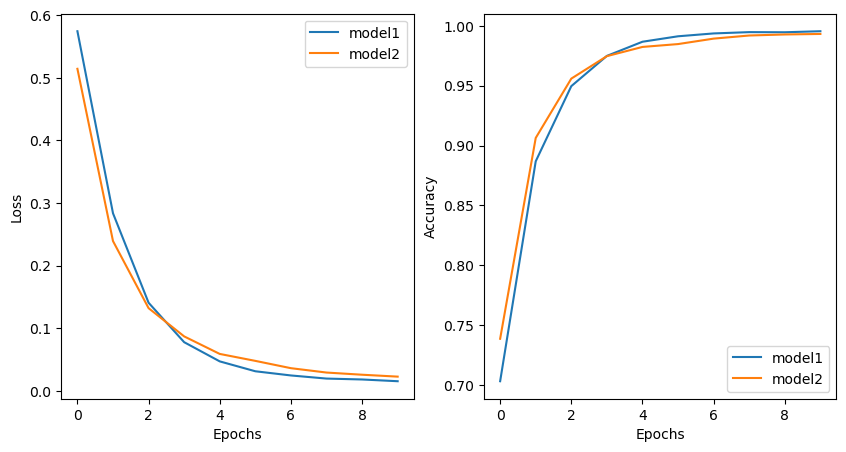

In [158]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Loss plots
ax1.plot(history1.history['loss'], label='model1')
ax1.plot(history2.history['loss'], label='model2')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy plots
ax2.plot(history1.history['accuracy'], label='model1')
ax2.plot(history2.history['accuracy'], label='model2')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

Единственное отличие- реккурентнка стартанула с лучшего скора